BIA660 Team 5 Mid Term Project Report Udemy 

In [1]:
# importing all the necessary libraries
import nltk
import re
import demoji
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
# import google.auth


In [2]:
# !pip3 install googleapiclient

In [3]:
from langdetect import detect
from collections import Counter
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
# from googleapiclient.discovery import build 
from sklearn.feature_extraction.text import CountVectorizer
import requests
from bs4 import BeautifulSoup, NavigableString 
import pandas as pd
from pyudemy import Udemy
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import re

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sagar\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

<h3>👉 Data Extraction </h3>
<ol>
<l1>Scraping Scripts</li>
</ol>

1. <b><u>Udemy Api :</u></b> Extracting the details of a Udemy Courses with the help of the google's Udemy data api

In [5]:
udemy = Udemy("cJALNHo2M7YpvbJZWpTU7EJNCuiFR3kNb1q6We17", "peYJf8jwuxpU4ZuPL5pR39mcC8KBOFvzEK9WoBhQTNZ6PKuA5jks3uODgA61neI6LRLH4hapuyitIhmiRgWee4UIMRebFBzVUbokUQoMfvsFlNYHox86e1IHFPigAAH1")

In [6]:
def getCourseDataBySearch(search_text):
    courses_data = udemy.courses(search = search_text)['results']
    course_ids = [course['id'] for course in courses_data[:5]]

    course_titles = [course['title'] for course in courses_data[:5]]
    course_ratings = list()
    course_prices = [course['price'] for course in courses_data[:5]]
    course_reviews = list()
    for course_id in course_ids: 
        reviews_list = list()
        rating_list = list()
        for i in range(50):
            reviews = udemy.course_reviews(id = course_id, page = i+1)
            for review in reviews['results']:
                if review['content']:
                    reviews_list.append(review['content'])
                    rating_list.append(review['rating'])
        course_ratings.append(rating_list)
        course_reviews.append(reviews_list)
    course_dict = {
        'ids': course_ids,
        'titles': course_titles,
        'ratings': course_ratings,
        'reveiws': course_reviews,
        'prices': course_prices
    }
    return course_dict

★ We can dynamically provide different course names but as an example we choose 'machine learning' as the course name input

In [7]:
# In this notebook we have used 'machine learning' as our keyword
course_name  = input("Enter the course of your interest : ")

Enter the course of your interest : pyspark


In [ ]:
res = getCourseDataBySearch(course_name)
# res.head()

In [41]:
res
res1 = []
for i in range(len(res['titles'])):
    obj = {}
    obj['title'] = res['titles'][i]
    obj['avg_rating'] = sum(res['ratings'][i])/len(res['ratings'][i])
    res1.append(obj)
res1

[{'title': 'Spark and Python for Big Data with PySpark',
  'avg_rating': 4.119565217391305},
 {'title': 'PYSPARK End to End Developer Course (Spark with Python)',
  'avg_rating': 4.8125},
 {'title': 'PySpark Essentials for Data Scientists (Big Data + Python)',
  'avg_rating': 4.196428571428571},
 {'title': 'PySpark Project- End to End Real Time Project Implementation',
  'avg_rating': 4.7444444444444445},
 {'title': 'PySpark & AWS: Master Big Data With PySpark and AWS',
  'avg_rating': 4.3359375}]

In [44]:
reviews_count = 0
for row in res['reveiws']:
    reviews_count += len(row)

reviews_count


300

In [10]:
list_all_courses_reveiws = [res['reveiws'][0], res['reveiws'][1], res['reveiws'][2], res['reveiws'][3], res['reveiws'][4]]

. converting all the list into the dataframes

In [11]:
video1_df = pd.DataFrame(list_all_courses_reveiws[0])
video2_df = pd.DataFrame(list_all_courses_reveiws[1])
video3_df = pd.DataFrame(list_all_courses_reveiws[2])
video4_df = pd.DataFrame(list_all_courses_reveiws[3])
video5_df = pd.DataFrame(list_all_courses_reveiws[4])

Making a list containing all the data frames so our operations can be applied in a more easy and dynamic way

In [12]:
df_all_comments = [video1_df, video2_df, video3_df, video4_df, video5_df] # list of all daraframes

<h3>👉 Exploratory data analysis and description </h3>

1. Data Cleaning

In [13]:
# defining the function for data cleaning

def cleaning_df(x):
    x = demoji.replace(x,'')
    x = re.sub(r'[^a-zA-Z0-9\s]', '', x)
    x = re.sub(r"http\S+", "", x)
    return x

In [14]:
# applying the same function on all the data frames
for i in range(len(df_all_comments)):
    df_all_comments[i][0] = df_all_comments[i][0].apply(cleaning_df)

2. Data Visualisation 


★ Based on the comments created a network for all the videos data frames

In [15]:
def build_semantic_network(x):

    vectorizer = CountVectorizer(ngram_range=(1,1), min_df=2,stop_words="english", max_features=50) # default unigram model
    X = vectorizer.fit_transform(x)
    X
    feature_names = vectorizer.get_feature_names_out()
    co_mat = (X.T * X) 
    co_mat.setdiag(0) 
    co_matrix = np.where(co_mat.todense() > 0, 1, 0)
    
    G = nx.from_numpy_array(co_matrix, create_using=nx.Graph()) 
    node_name = dict(zip(range(0,len(list(G.nodes()))),feature_names))  
    G = nx.relabel_nodes(G, node_name) 

    plt.figure(figsize=(7, 7))

    node_size= [x*1000 for x in nx.eigenvector_centrality_numpy(G).values()]
    pos=nx.spring_layout(G)
    edge_color='grey'

    nx.drawing.nx_pylab.draw_networkx(G,node_size=node_size, pos=pos, edge_color=edge_color, with_labels=True, font_size=12)
    plt.title('The semantic network of the Searched Course')
    plt.axis("off") 
    plt.show()

    return G

Graph for df  1


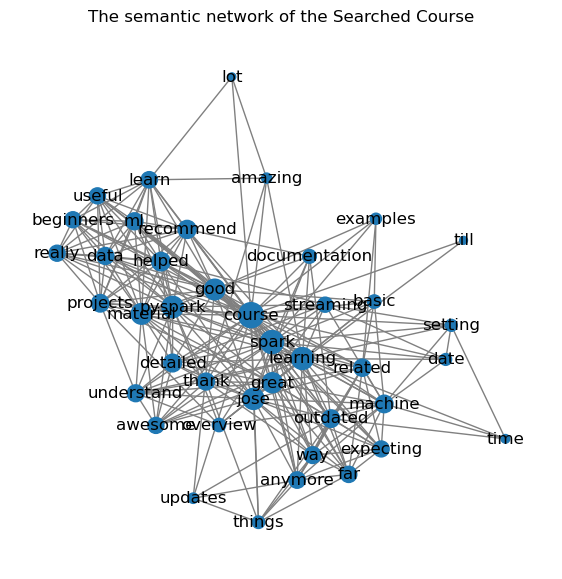

Graph for df  2


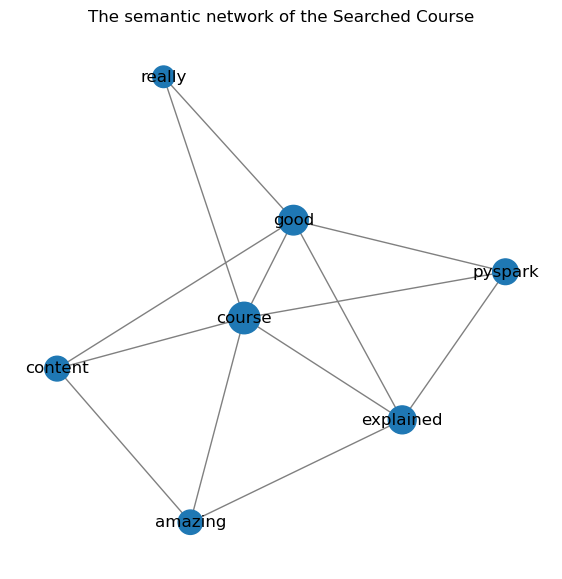

Graph for df  3


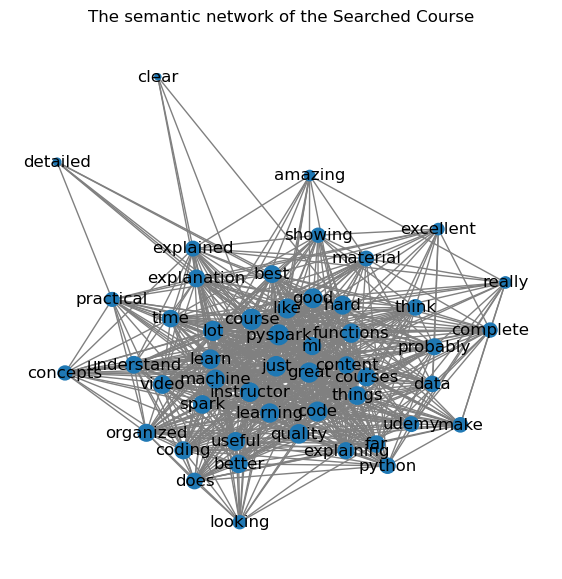

Graph for df  4


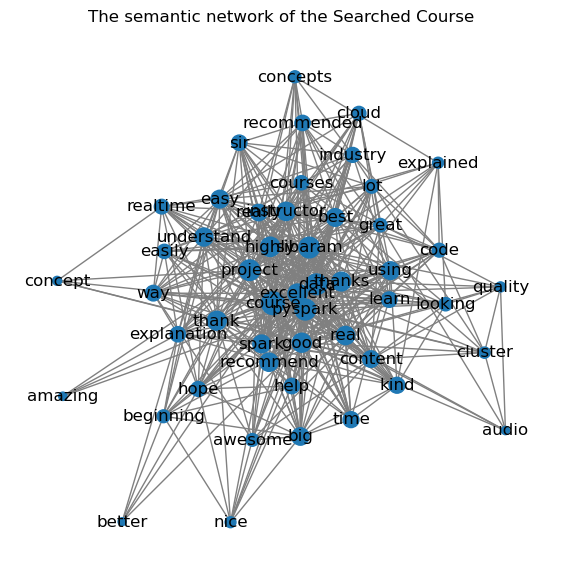

Graph for df  5


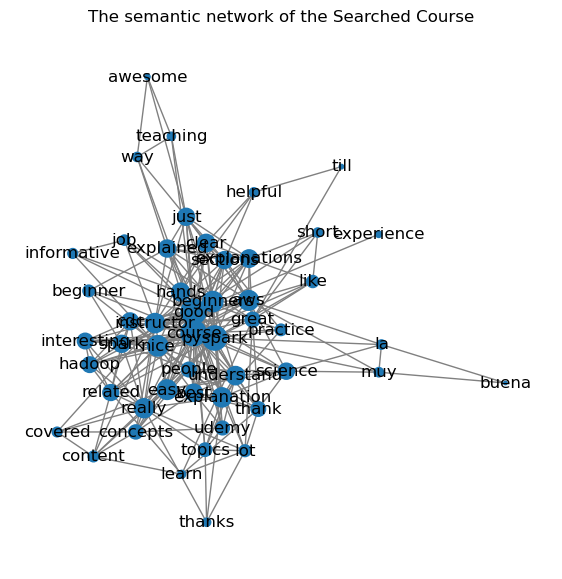

In [16]:
for i  in range(len(df_all_comments)):
    print('Graph for df ', i+1)
    build_semantic_network(set(df_all_comments[i][0]))

★ As a result we can see all the networks are primarily focused onto the <b><u> 'python' </u></b> node which is quite obvious as our search query was 'python'

3. Tokenization followed by the Counter to get observe the word frequency 

In [17]:
def word_frequency_calculator(df):
    words = []

    for row in df[0]:
        sentence_tokens = nltk.word_tokenize(row)
        words.extend(sentence_tokens)

    filtered_tokens = [word.strip().lower() for word in words if word.lower() not in set(stopwords.words('english'))]

    return Counter(filtered_tokens)

In [18]:
word_count_list = []
for i in df_all_comments:
    word_count_list.append(word_frequency_calculator(i))

In [19]:
for i in word_count_list:
    print(i)

Counter({'course': 21, 'good': 17, 'spark': 10, 'learning': 8, 'machine': 7, 'pyspark': 6, 'jose': 6, 'amazing': 5, 'get': 4, 'great': 4, 'part': 4, 'outdated': 4, 'far': 4, 'projects': 4, 'data': 4, 'detailed': 3, 'material': 3, 'thank': 3, 'streaming': 3, 'things': 3, 'awesome': 2, 'understand': 2, 'lot': 2, 'learn': 2, 'examples': 2, 'helped': 2, 'time': 2, 'till': 2, 'date': 2, 'expecting': 2, 'useful': 2, 'beginners': 2, 'approach': 2, 'ml': 2, 'recommend': 2, 'see': 2, 'really': 2, 'way': 2, 'documentation': 2, 'overview': 2, 'basic': 2, 'alot': 2, 'related': 2, 'also': 2, 'anymore': 2, 'bueno': 2, 'excelente': 2, 'es': 2, 'que': 2, 'con': 2, 'el': 2, 'se': 2, 'setting': 2, 'updates': 2, 'started': 1, 'scratch': 1, 'description': 1, 'setup': 1, 'overall': 1, 'easy': 1, 'slides': 1, 'could': 1, 'graph': 1, 'images': 1, 'instead': 1, 'long': 1, 'texts': 1, 'thanks': 1, 'important': 1, 'live': 1, 'example': 1, 'super': 1, 'cource': 1, 'wasting': 1, 'yes': 1, 'bought': 1, 'disappoint

4. Visualisation of the most frequent words in each video comments

In [20]:
def plot_word_dist(x, y, i):
    plt.figure(figsize=(15,6))
    plt.bar(y, x, color=['black', 'red', 'cyan', 'green', 'blue'])
    plt.title("Most Frequent Words in video "+str(i+1))
   
    plt.xlabel("Most Frequent Words")
    plt.ylabel("Counts")

    plt.show()

Most Common Word :  [('course', 21), ('good', 17), ('spark', 10), ('learning', 8), ('machine', 7), ('pyspark', 6), ('jose', 6), ('amazing', 5), ('get', 4), ('great', 4)]


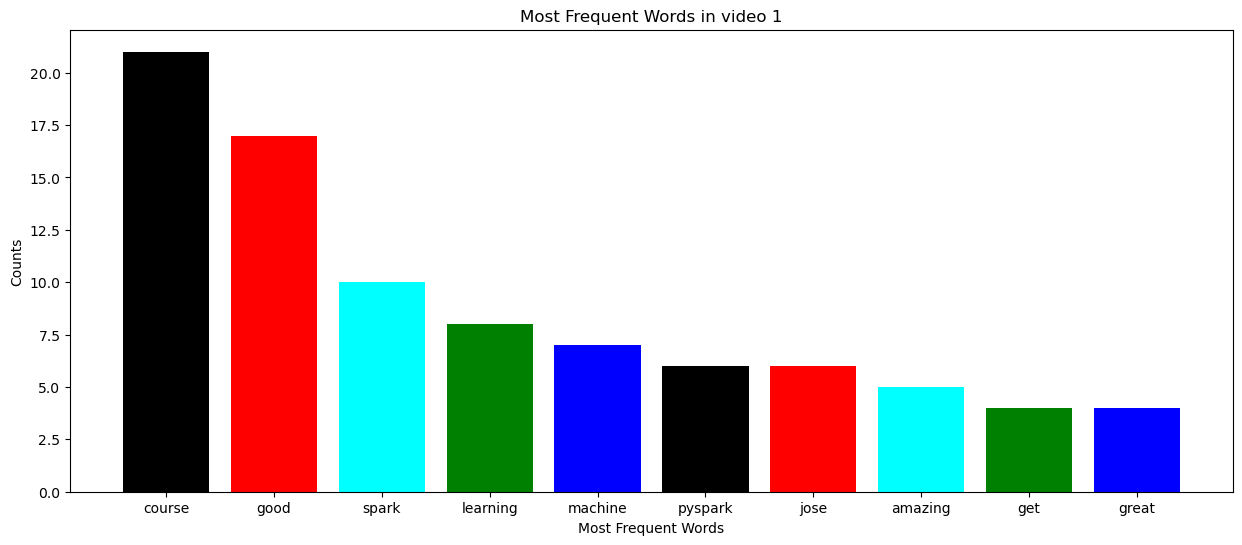

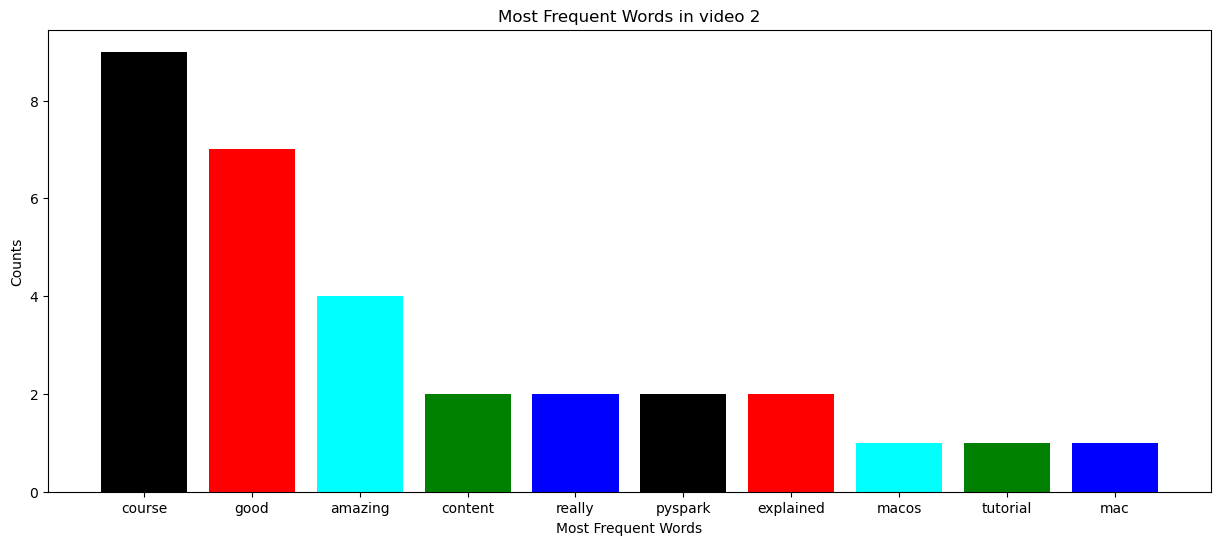

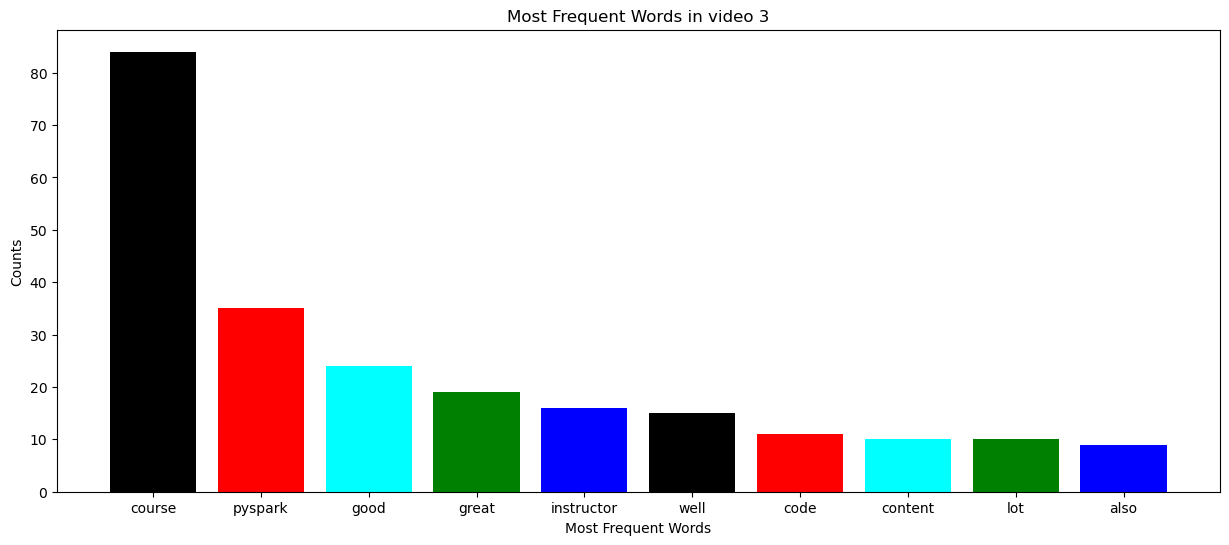

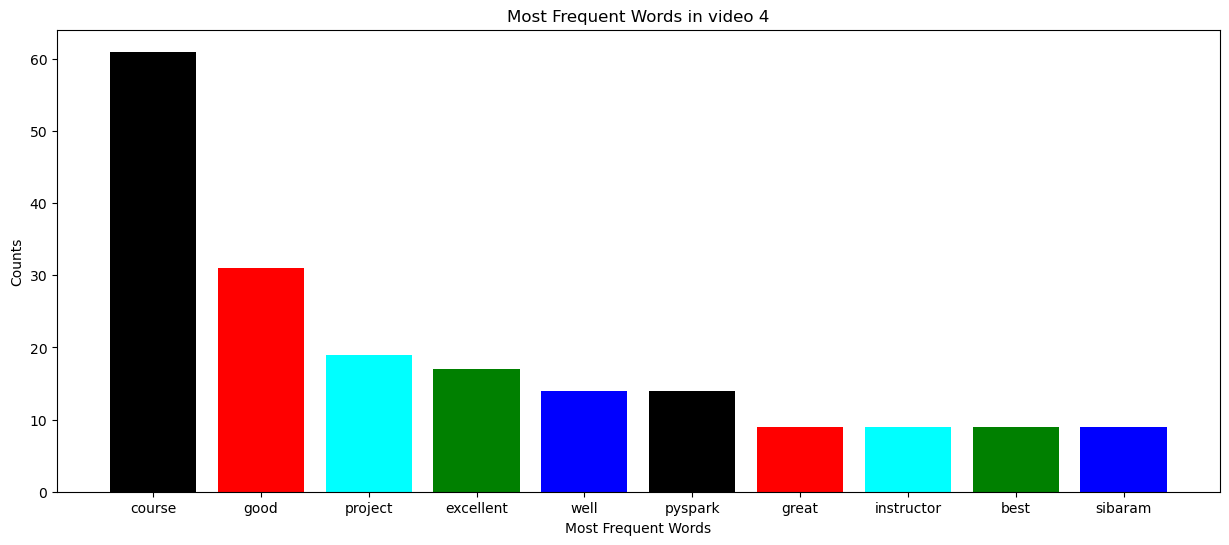

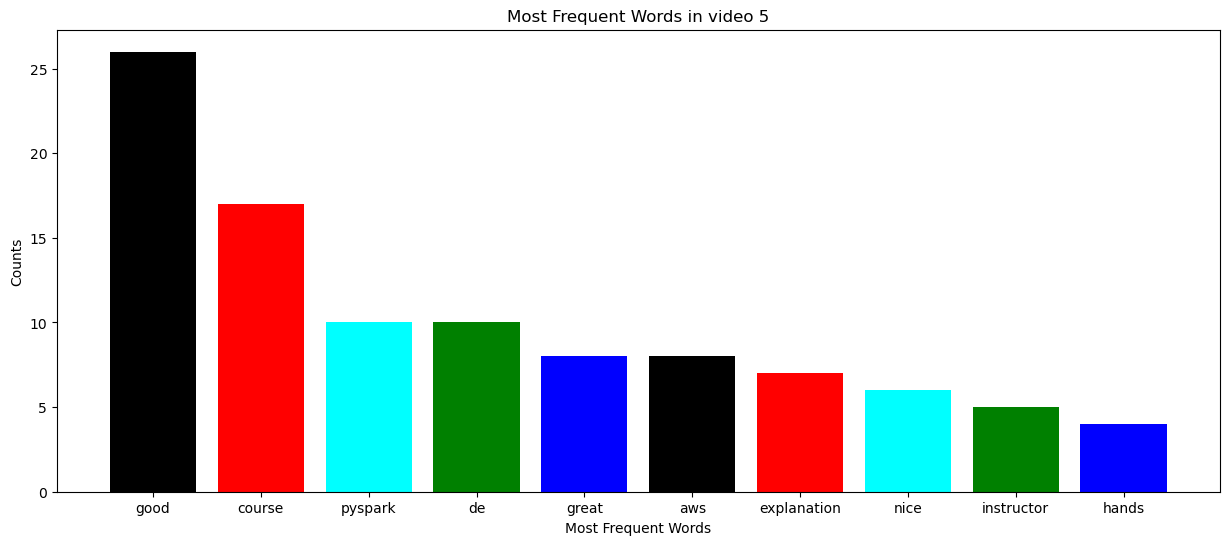

In [21]:
print("Most Common Word : ", word_count_list[0].most_common(10))
for i in range(5):
    x = []
    y = []
    for j in word_count_list[i].most_common(10):
        x.append(j[1])
        y.append(j[0])
    plot_word_dist(x, y, i)

★ Our search was 'machine learning' and corresponding to that we have the most common word as 'ml, learning, supervised, etc'

5. Visualisation of the distribution of the ratings for each of the courses 

In [22]:
all_ratings = [res['ratings'][0], res['ratings'][1], res['ratings'][2], res['ratings'][3], res['ratings'][4]]

Ratings distribution for course 1


{'bodies': [<matplotlib.collections.PolyCollection at 0x1b7ac8e5820>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1b7ac8e5fa0>,
 'cmins': <matplotlib.collections.LineCollection at 0x1b7ad951b20>,
 'cbars': <matplotlib.collections.LineCollection at 0x1b7ad951ee0>}

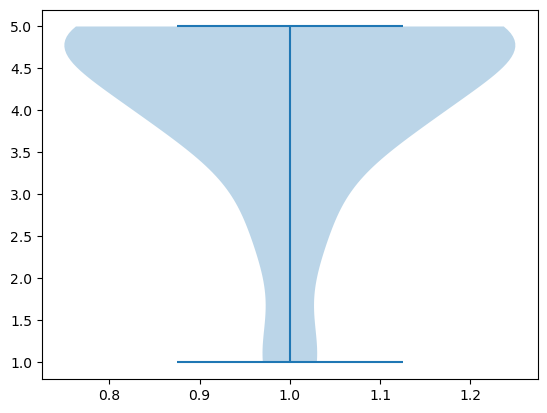

In [23]:
print('Ratings distribution for course 1')
plt.violinplot(all_ratings[0])

Ratings distribution for course 2


{'bodies': [<matplotlib.collections.PolyCollection at 0x1b7ad994160>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1b7ad9940a0>,
 'cmins': <matplotlib.collections.LineCollection at 0x1b7ad994730>,
 'cbars': <matplotlib.collections.LineCollection at 0x1b7ad994af0>}

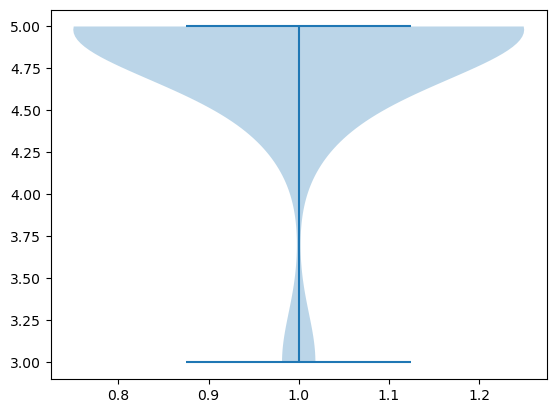

In [24]:
print('Ratings distribution for course 2')
plt.violinplot(all_ratings[1])

Ratings distribution for course 3


{'bodies': [<matplotlib.collections.PolyCollection at 0x1b7ad9ffa90>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1b7ad9ffa00>,
 'cmins': <matplotlib.collections.LineCollection at 0x1b7ada0d190>,
 'cbars': <matplotlib.collections.LineCollection at 0x1b7ada0d550>}

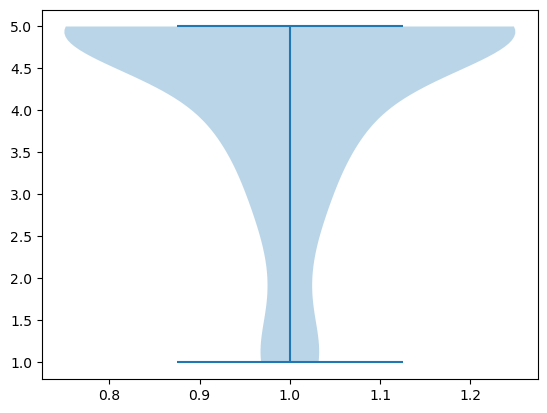

In [25]:
print('Ratings distribution for course 3')
plt.violinplot(all_ratings[2])

Ratings distribution for course 4


{'bodies': [<matplotlib.collections.PolyCollection at 0x1b7ada784f0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1b7ada78430>,
 'cmins': <matplotlib.collections.LineCollection at 0x1b7ada78bb0>,
 'cbars': <matplotlib.collections.LineCollection at 0x1b7ada78f70>}

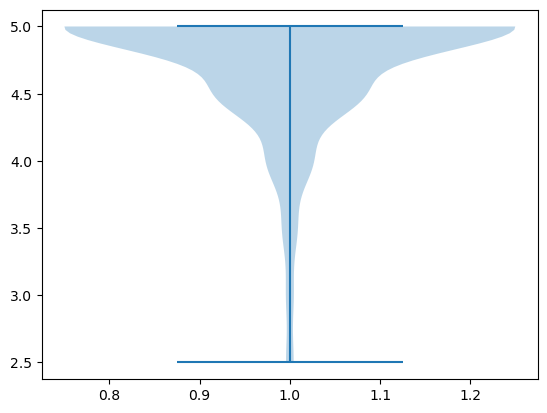

In [26]:
print('Ratings distribution for course 4')
plt.violinplot(all_ratings[3])

Ratings distribution for course 5


{'bodies': [<matplotlib.collections.PolyCollection at 0x1b7adb17fd0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1b7adb17f40>,
 'cmins': <matplotlib.collections.LineCollection at 0x1b7adb266d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x1b7adb26a90>}

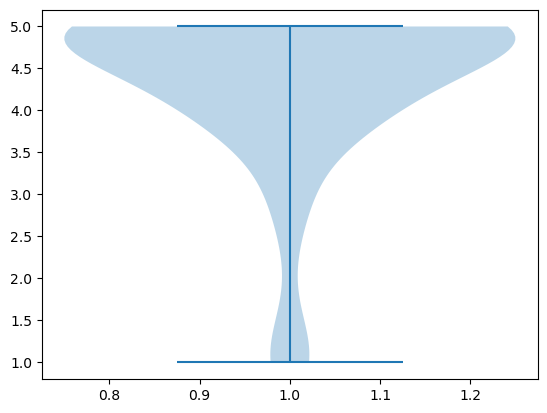

In [27]:
print('Ratings distribution for course 5')
plt.violinplot(all_ratings[4])

7. Performance Analysis using Sentiment Analysis

a. calculating the sentiments score as per the each comments in each video

In [28]:
analyzer = SentimentIntensityAnalyzer() 

def get_sentiment_scores(x):
    sentiment = analyzer.polarity_scores(x)
    return sentiment['compound']

for i in df_all_comments:       
    i['score'] = i[0].apply(get_sentiment_scores)

b. distributing the score into three categories positive as 1, neutral as 0, negative as -1

In [29]:
def get_score_cat(x):
    if x == 0:
        return 0
    if x > 0:
        return 1
    else:
        return -1 

In [30]:
for i in df_all_comments:
    i['score_cat'] = i['score'].apply(get_score_cat)

c. visualisation of comments based on the number of positive, neutral and negative values

Video 1 sentimental category plos


<AxesSubplot:xlabel='score_cat', ylabel='count'>

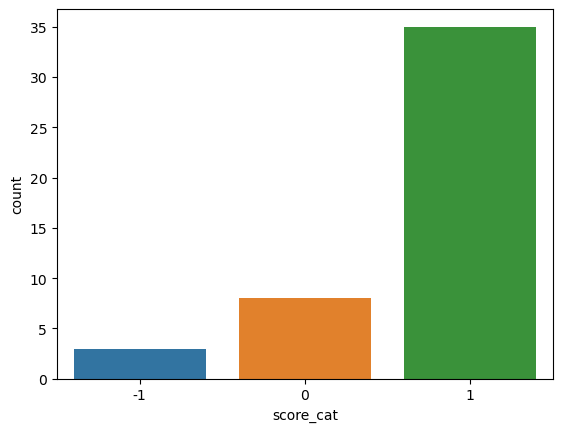

In [31]:
print("Video 1 sentimental category plos")
sns.countplot(x=df_all_comments[0]['score_cat'])

Video 2 sentimental category plos


<AxesSubplot:xlabel='score_cat', ylabel='count'>

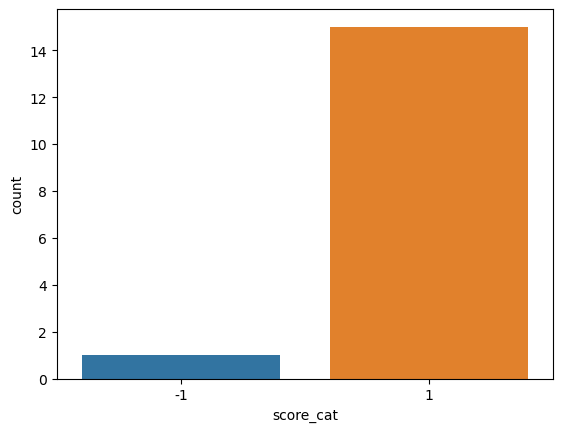

In [32]:
print("Video 2 sentimental category plos")
sns.countplot(x=df_all_comments[1]['score_cat'])

Video 3 sentimental category plos


<AxesSubplot:xlabel='score_cat', ylabel='count'>

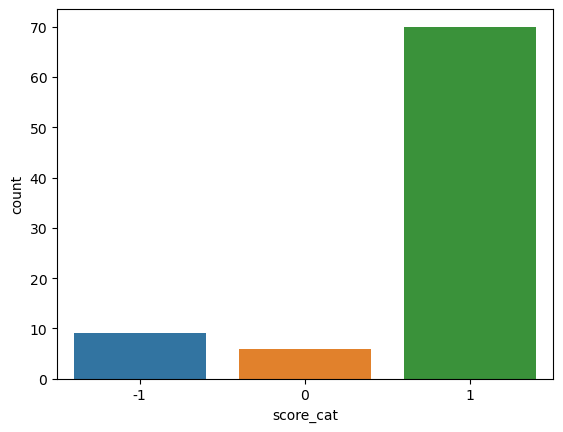

In [33]:
print("Video 3 sentimental category plos")
sns.countplot(x=df_all_comments[2]['score_cat'])

Video 4 sentimental category plos


<AxesSubplot:xlabel='score_cat', ylabel='count'>

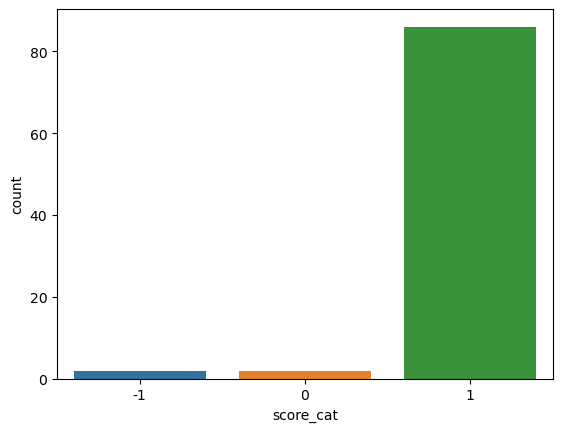

In [34]:
print("Video 4 sentimental category plos")
sns.countplot(x=df_all_comments[3]['score_cat'])

Video 5 sentimental category plos


<AxesSubplot:xlabel='score_cat', ylabel='count'>

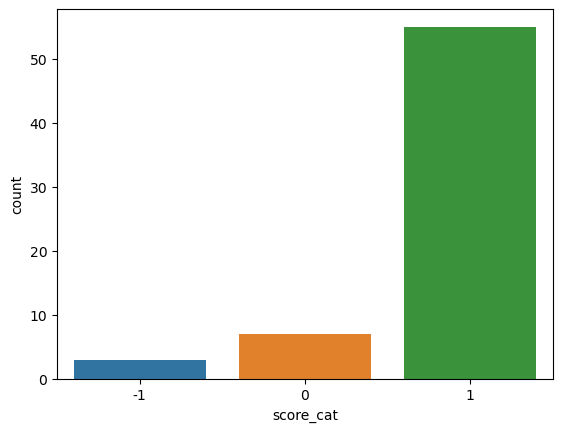

In [35]:
print("Video 5 sentimental category plos")
sns.countplot(x=df_all_comments[4]['score_cat'])

In [36]:
for i, j in enumerate(df_all_comments):
    print("Average Sentimental Score for video ", res['titles'][i])
    print(j['score'].mean())

Average Sentimental Score for video  Spark and Python for Big Data with PySpark
0.39821956521739127
Average Sentimental Score for video  PYSPARK End to End Developer Course (Spark with Python)
0.5090875
Average Sentimental Score for video  PySpark Essentials for Data Scientists (Big Data + Python)
0.4818164705882352
Average Sentimental Score for video  PySpark Project- End to End Real Time Project Implementation
0.617251111111111
Average Sentimental Score for video  PySpark & AWS: Master Big Data With PySpark and AWS
0.4391846153846153


★ For each title is the corresponding average sentiment score

😀 Thank you !